In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit, least_squares, minimize
import matplotlib

matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 14

In [10]:
# Load the major plot
path = r"G:\Shared drives\L10237-TG-10nm\All Document\fig3_processing\data"

qt_2d_12_right = np.load(path + r"\12tg_right_2d_qt.npy")
qomega_2d_12_right = np.load(path + r"\12tg_right_2d_qomega.npy")
qarray_2d_12_right = np.load(path + r"\12tg_right_2d_qarray.npy") * np.pi * 2
phonon_2d_12_right = np.load(path + r"\12tg_right_2d_LA.npy")
phonon_2d_12_right_to = np.load(path + r"\12tg_right_2d_TO.npy")
time_right = np.load(path + r"\12nm_right_1d_t.npy")
omega_right = np.load(path + r'\12nm_right_1d_omega_v2.npy')

# Load the major plot
qt_2d_12_left = np.load(path + r"\12tg_left_2d_qt.npy")
qomega_2d_12_left = np.load(path + r"\12tg_left_2d_qomega.npy")
qarray_2d_12_left = np.load(path + r"\12tg_left_2d_qarray.npy") * np.pi * 2
phonon_2d_12_left = np.load(path + r"\12tg_left_2d_LA.npy")
phonon_2d_12_left_to = np.load(path + r"\12tg_left_2d_TO.npy")
time_left = np.load(path + r"\12nm_left_1d_t.npy")
omega_left = np.load(path + r'\12nm_left_1d_omega_v2.npy')

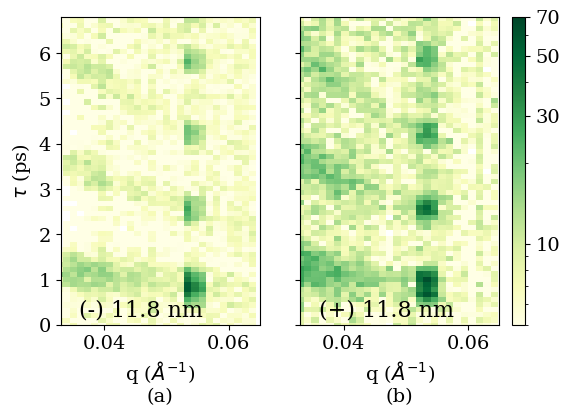

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figheight(4)
fig.set_figwidth(6.5)

ax1 = axes[0]
ax2 = axes[1]

xlim = [0.033, 0.065]
vmax = 70
vmin = 5
cmap = 'BuPu'
#cmap='cividis'
cmap = 'magma'
cmap = 'YlGn'
# --------------------------------------------------------------
im1 = ax1.imshow(qt_2d_12_left + 6,
                 cmap=cmap,
                 aspect='auto',
                 norm=LogNorm(vmin=vmin, vmax=vmax),
                 #vmin=vmin, vmax=vmax,
                 origin='lower',
                 extent=[qarray_2d_12_left[0], qarray_2d_12_left[-1],
                         time_left[0] - 3.67192887, time_left[-1] - 3.67192887, ])
ax1.set_xlabel(r"q ($\AA^{-1}$)" + "\n(a)")
ax1.set_ylim([0, 6.8])
ax1.set_xlim(xlim)
ax1.set_ylabel(r"$\tau$ (ps)")

im2 = ax2.imshow(qt_2d_12_right + 6,
                 cmap=cmap,
                 aspect='auto',
                 norm=LogNorm(vmin=vmin, vmax=vmax),
                 #vmin=vmin, vmax=vmax,
                 origin='lower',
                 extent=[qarray_2d_12_right[0], qarray_2d_12_right[-1],
                         time_right[0] - 3.67192887, time_right[-1] - 3.67192887, ])
ax2.set_xlabel(r"q ($\AA^{-1}$)" + "\n(b)")
ax2.set_ylim([0, 6.8])
ax2.set_yticklabels('')
ax2.set_xlim(xlim)
# -----------------------------------
ax1.text(x=0.036, y=0.2, s='(-) 11.8 nm', color='k', fontsize=16)
ax2.text(x=0.036, y=0.2, s='(+) 11.8 nm', color='k', fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.11, 0.02, 0.771])
cbar_img = fig.colorbar(im2, cax=cbar_ax, ticks=[10, 30, 50, 70])
cbar_img.ax.set_yticklabels(['10', '30', '50', '70'])

#plt.savefig("./fig3.png", dpi=300, bbox_inches='tight')
plt.show()

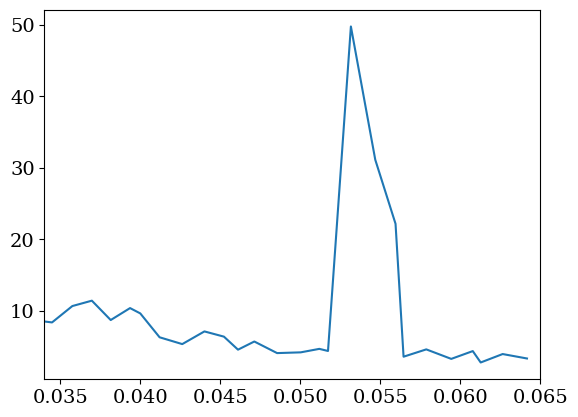

In [98]:
plt.plot(qarray_2d_12_left, np.max(qt_2d_12_left, axis=0))
plt.xlim([0.034, 0.065])
plt.show()

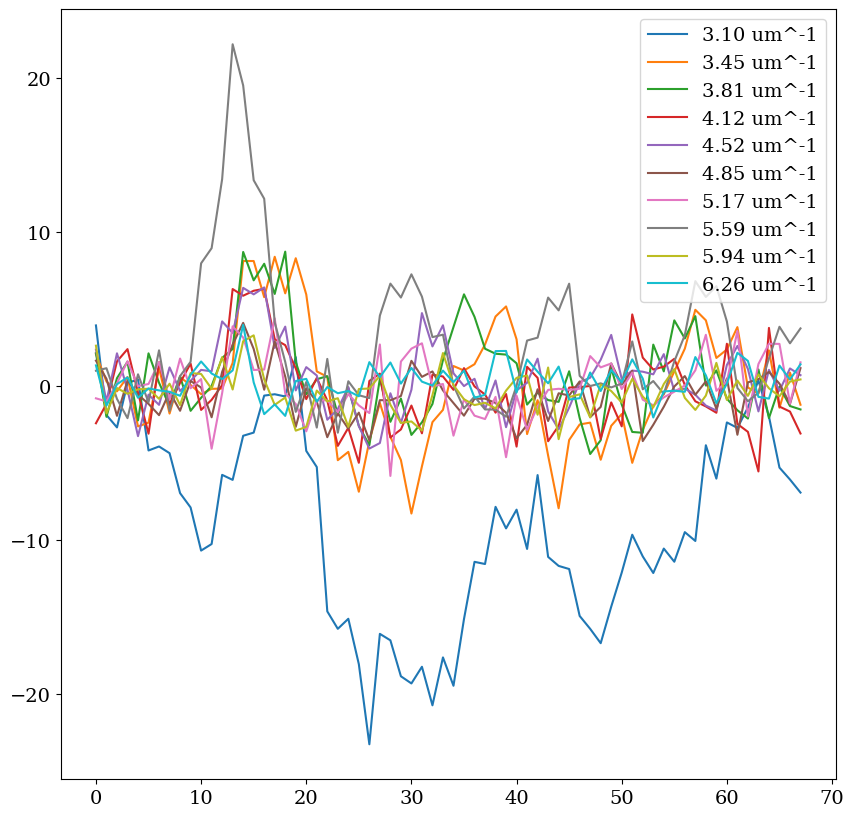

In [13]:
q_num = qt_2d_12_left.shape[1]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
for q_idx in range(0, q_num, 3):
    ax.plot(qt_2d_12_left[:, q_idx], label="{:.2f} um^-1".format(qarray_2d_12_left[q_idx] * 100))

ax.legend()
plt.show()

In [112]:
## Create mask for the left peak
start_time_left = 3.6
stop_time_left = 10.5

start_q_left = 0.034
stop_q_left = 0.05

"""
I would like to perform the following fitting

signal = (A exp(-q^2 sigma^2 / 2) / q^2 * exp(-t/taus) * (1-cos(q v t)))^2 + c
"""

## Create a mask for the 
mask = np.ones_like(qt_2d_12_left, dtype=bool)
mask[:, :] *= np.logical_and(time_left > start_time_left, time_left < stop_time_left)[:, np.newaxis]
mask[:, :] *= np.logical_and(qarray_2d_12_left > start_q_left, qarray_2d_12_left < stop_q_left)[np.newaxis:]

t = (time_left - 3.67192887)[:, np.newaxis]
q = qarray_2d_12_left[np.newaxis, :]

measure_left = np.copy(qt_2d_12_left)


def loss_fun_left(x):
    """
    x[0] = A
    x[1] = sigma^2 / 2   A^2
    x[2] = 1/taus        ps^-1 
    x[3] = v         3000 m/s = 3e3 * 10e10 / 1e12 = 30 A/ps
    x[4] = c     unitless
    """
    # Get the loss from the left peak
    val_left = x[0] * np.exp(- q ** 2 * x[1]) #/ q ** 2
    val_left = val_left * np.exp(-t * x[2]) * (1 - np.cos(q * x[3] * t))
    val_left = np.square(val_left) + x[4]
    
    diff = (val_left - measure_left)[mask]
    val_left = np.sum(np.square(diff))

    return val_left

res_left = minimize(loss_fun_left,
                    x0=np.array([2.62241549e+00,  3.26725659e+02,  1.11638604e-01,  7.31707291e+01, -1.26376927e+00], ),
                    method=None,
                    bounds=((0.00001, 10000,),
                            (0.0, 400.,),
                            (0.00001, 4.),
                            (1, 100.),
                            (-10, 1000),
                            ),
                    )
print(res_left.success)
print(res_left.x)
print(np.sqrt(2 * res_left.x[1]))

True
[ 2.62241453e+00  3.26725659e+02  1.11639113e-01  7.31707291e+01
 -1.26376956e+00]
25.562693872208094


In [113]:
# Get the fitted value
amplitude_left = res_left.x[0] * np.exp(- q ** 2 * res_left.x[1]) #/ q ** 2
fit_left = amplitude_left * np.exp(-t * res_left.x[2]) * (1 - np.cos(q * res_left.x[3] * t))
fit_left = np.square(fit_left) + res_left.x[4]

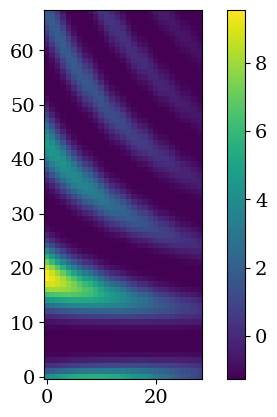

In [114]:
plt.imshow(fit_left, origin='lower')
plt.colorbar()
plt.show()

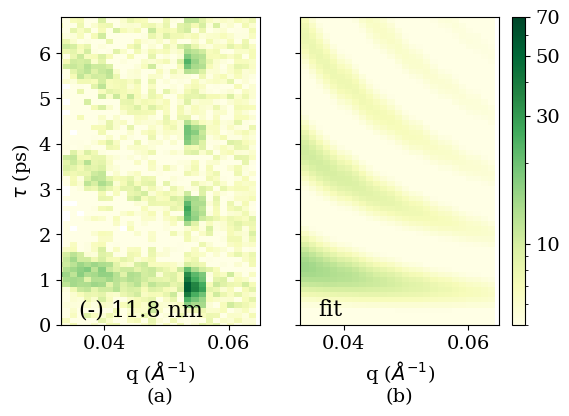

In [115]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figheight(4)
fig.set_figwidth(6.5)

ax1 = axes[0]
ax2 = axes[1]

xlim = [0.033, 0.065]
vmax = 70
vmin = 5
cmap = 'BuPu'
#cmap='cividis'
cmap = 'magma'
cmap = 'YlGn'
# --------------------------------------------------------------
im1 = ax1.imshow(qt_2d_12_left + 6,
                 cmap=cmap,
                 aspect='auto',
                 norm=LogNorm(vmin=vmin, vmax=vmax),
                 #vmin=vmin, vmax=vmax,
                 origin='lower',
                 extent=[qarray_2d_12_left[0], qarray_2d_12_left[-1],
                         time_left[0] - 3.67192887, time_left[-1] - 3.67192887, ])
ax1.set_xlabel(r"q ($\AA^{-1}$)" + "\n(a)")
ax1.set_ylim([0, 6.8])
ax1.set_xlim(xlim)
ax1.set_ylabel(r"$\tau$ (ps)")

im2 = ax2.imshow(fit_left + 6,
                 cmap=cmap,
                 aspect='auto',
                 norm=LogNorm(vmin=vmin, vmax=vmax),
                 #vmin=vmin, vmax=vmax,
                 origin='lower',
                 extent=[qarray_2d_12_left[0], qarray_2d_12_left[-1],
                         time_left[0] - 3.67192887, time_left[-1] - 3.67192887, ])
ax2.set_xlabel(r"q ($\AA^{-1}$)" + "\n(b)")
ax2.set_ylim([0, 6.8])
ax2.set_yticklabels('')
ax2.set_xlim(xlim)
# -----------------------------------
ax1.text(x=0.036, y=0.2, s='(-) 11.8 nm', color='k', fontsize=16)
ax2.text(x=0.036, y=0.2, s='fit', color='k', fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.11, 0.02, 0.771])
cbar_img = fig.colorbar(im2, cax=cbar_ax, ticks=[10, 30, 50, 70])
cbar_img.ax.set_yticklabels(['10', '30', '50', '70'])

#plt.savefig("./fig3.png", dpi=300, bbox_inches='tight')
plt.show()

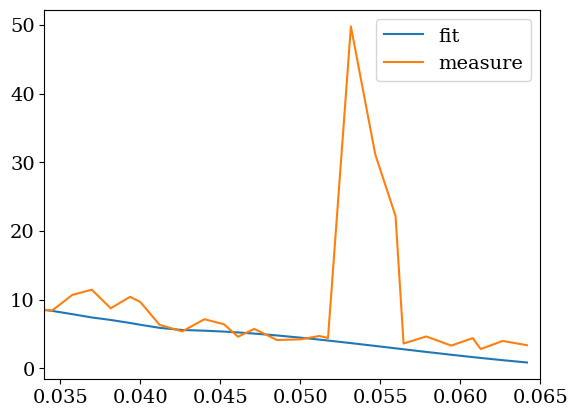

In [116]:
plt.plot(qarray_2d_12_left, np.max(fit_left, axis=0), label='fit')
plt.plot(qarray_2d_12_left, np.max(qt_2d_12_left, axis=0), label='measure')
plt.legend()
plt.xlim([0.034, 0.065])
plt.show()

In [ ]:

mask_left = np.ones_like(time_left, dtype=bool)
mask_left[time_left < start_time_left] = False
mask_left[time_left > stop_time_left] = False

time_fit_left = time_left[mask_left]
val_fit_left = i_both_12_left[mask_left]

# Create mask for the right peak
start_time_right = 3.6
stop_time_right = 14

mask_right = np.ones_like(t_12_right, dtype=bool)
mask_right[t_12_right < start_time_right] = False
mask_right[t_12_right > stop_time_right] = False

time_fit_right = t_12_right[mask_right]
val_fit_right = i_both_12_right[mask_right]


def loss_fun_both(x):
    # Get the loss from the left peak
    val_left = (x[0] +
                x[1] * np.square(np.exp(-(time_fit_left - x[2]) / x[3])
                                 - np.cos(x[4] * (time_fit_left - x[2])))
                * np.exp(-(time_fit_left - x[2]) / x[5]))

    val_left = np.sum(np.square((val_left - val_fit_left)) * np.square(val_fit_left))

    # Get the loss from the right peak
    val_right = (x[6] +
                 x[7] * np.square(np.exp(-(time_fit_right - x[2]) / x[3])
                                  - np.cos(x[4] * (time_fit_right - x[2])))
                 * np.exp(-(time_fit_right - x[2]) / x[5]))

    val_right = np.sum(np.square((val_right - val_fit_right)) * np.square(val_fit_right))

    return val_left + val_right


res_both = minimize(loss_fun_both,
                    x0=np.array([38, 26, 2.9, 30., 0.79 * np.pi, 4., 37, 26], ),
                    method=None,
                    bounds=((30, 40,),
                            (1., 100.,),
                            (2., 4.),
                            (1, 100.),
                            (0.2 * np.pi, np.pi * 2),
                            (1., 100.),
                            (30, 50,),
                            (1., 100.,),
                            ),
                    )
print(res_both.success)

# Get a new time array for a better t and omega resolution
time_array_new = np.linspace(start=3, stop=50, num=5000)

fit_right = (res_both.x[6] +
             res_both.x[7] * np.square(np.exp(-(time_array_new - res_both.x[2]) / res_both.x[3])
                                       - np.cos(res_both.x[4] * (time_array_new - res_both.x[2])))
             * np.exp(-(time_array_new - res_both.x[2]) / res_both.x[5]))

fit_left = (res_both.x[0] +
            res_both.x[1] * np.square(np.exp(-(time_array_new - res_both.x[2]) / res_both.x[3])
                                      - np.cos(res_both.x[4] * (time_array_new - res_both.x[2])))
            * np.exp(-(time_array_new - res_both.x[2]) / res_both.x[5]))

# Get the fourier transformation
omega_left_fit = np.fft.fftshift(np.fft.fftfreq(time_array_new.shape[0], d=time_array_new[1] - time_array_new[0]))
idx = np.argmin(np.abs(omega_left_fit - 0.59185))
freq_left_fit = np.square(np.abs(np.fft.fftshift(np.fft.fft(fit_left))))
freq_left_fit /= freq_left_fit[idx]

omega_right_fit = np.fft.fftshift(np.fft.fftfreq(time_array_new.shape[0], d=time_array_new[1] - time_array_new[0]))
idx = np.argmin(np.abs(omega_right_fit - 0.59185))
freq_right_fit = np.square(np.abs(np.fft.fftshift(np.fft.fft(fit_right)))) / (
        time_array_new.shape[0] / time_fit_right.shape[0])
freq_right_fit /= freq_right_fit[idx]

print(res_both.x)
fig, axes = plt.subplots(ncols=2, nrows=2)
axes[0, 0].plot(time_array_new - res_both.x[2], fit_left, 'r')
axes[0, 0].plot(t_12_left - res_both.x[2], i_both_12_left, 'b', marker='.', linestyle='', markersize=5)
axes[0, 0].set_xlim([-0.1, 7])
axes[0, 0].set_ylim([20, 160])

axes[0, 1].plot(time_array_new - res_both.x[2], fit_right, 'r')
axes[0, 1].plot(t_12_right - res_both.x[2], i_both_12_right, 'b', marker='.', linestyle='', markersize=5)
axes[0, 1].set_xlim([-0.1, 7])
axes[0, 1].set_ylim([20, 160])

axes[1, 0].plot(omega_left_fit, freq_left_fit, 'r')
axes[1, 0].plot(omega_12_left, f_both_12_left, 'b', marker='.', linestyle='', markersize=5)
axes[1, 0].set_xlim([0.1, 1.5])
axes[1, 0].set_ylim([0, 1.5])

axes[1, 1].plot(omega_right_fit, freq_right_fit, 'r')
axes[1, 1].plot(omega_12_right, f_both_12_right, 'b', marker='.', linestyle='', markersize=5)
axes[1, 1].set_xlim([0.1, 1.5])
axes[1, 1].set_ylim([0, 1.5])

plt.tight_layout()
plt.show()